# Проектная практика: обучение модели и загрузка в HF

## Импорты

In [1]:
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from catboost import CatBoostRegressor
from datasets import Dataset, DatasetDict, Features, Value, DatasetInfo
from huggingface_hub import HfApi, create_repo, notebook_login, DatasetCardData
from sklearn.model_selection import train_test_split

## Загрузка данных

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/AlekseiAgarkov/MIFIML-2-Sem1-M25-525-Project-Practice/refs/heads/main/data/sim_data_metrics_20251214.csv")
df.head()

,simulation_id,random_seed,n_agents,exposed_to_pollutant,exposed_to_pollutant_share,sim_duration,initially_infected,lowest_immunity,highest_immunity,mask_beta_penalty,...,recovered_330d,infected_360d,exposed_360d,recovered_360d,max_infected,max_exposed,max_recovered,total_infected,total_exposed,total_recovered
0,80fc2eb,143,10000,2458,0.2458,365,4,0.2,0.75,0.50,...,9803,10000,9996,9989,1026,449,9998,10000,9996,9998
1,7862604,106,10000,2458,0.2458,365,4,0.1,0.75,0.50,...,10000,10000,9996,10000,1220,554,10000,10000,9996,10000
2,b719a0c,1972,10000,2458,0.2458,365,6,0.3,0.60,0.50,...,878,1103,1133,1002,101,47,1022,1123,1164,1022
3,828048b,1345,10000,2458,0.2458,365,6,0.3,0.60,0.50,...,1106,1265,1293,1192,108,52,1213,1281,1307,1213
4,5db4c15,1557,10000,2458,0.2458,365,10,0.2,0.75,0.25,...,1715,2123,2176,1961,165,79,2001,2156,2213,2001


## Общий функционал

In [3]:
TARGET = "infected_90d"
TEST_SIZE = 0.3
RANDOM_STATE = 42

In [4]:
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df = fi_df.sort_values(by='feature_importance', ascending=True)

    fig = go.Figure(data=[
        go.Bar(
            x=fi_df['feature_importance'],
            y=fi_df['feature_names'],
            orientation='h',
            text=fi_df['feature_importance'].round(3),
            textposition='outside'
        )
    ])

    fig.update_layout(
        title=model_type + ' feature importance',
        xaxis_title='Feature Importance',
        yaxis_title='',
        showlegend=False,
        height=600
    )

    return fig

In [5]:
def plot_learning_curves(model, model_description, metric="RMSE"):
  eval_results = model.get_evals_result()
  train_metric = eval_results['learn'][metric]
  val_metric = eval_results['validation'][metric]
  iterations = list(range(len(train_metric)))

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=iterations, y=train_metric,
                          mode='lines', name=f'Train {metric}',
                          line=dict(color='blue')))
  fig.add_trace(go.Scatter(x=iterations, y=val_metric,
                          mode='lines', name=f'Validation {metric}',
                          line=dict(color='red')))
  fig.update_layout(title=f'Learning Curves for {model_description}',
                    xaxis_title='Iterations',
                    yaxis_title=metric,
                    hovermode='x unified')

  fig.show()

## Модель с фокусом на загрязнитель

In [6]:
pollutant_cols = [
    'initially_infected',
    'lowest_immunity',
    'highest_immunity',
    'mask_beta_penalty',
    'pollutant_immunity_reduction'
    ]
pollutant_training_data = df[[*pollutant_cols, TARGET]]
pollutant_training_data.head()

,initially_infected,lowest_immunity,highest_immunity,mask_beta_penalty,pollutant_immunity_reduction,infected_90d
0,4,0.2,0.75,0.50,0.2,2769
1,4,0.1,0.75,0.50,0.1,3258
2,6,0.3,0.60,0.50,0.3,166
3,6,0.3,0.60,0.50,0.1,144
4,10,0.2,0.75,0.25,0.3,351


In [7]:
pollutant_X = pollutant_training_data[pollutant_cols]
pollutant_y = pollutant_training_data[TARGET]
pollutant_X_train, pollutant_X_test, pollutant_y_train, pollutant_y_test = train_test_split(pollutant_X,
                                                                                            pollutant_y,
                                                                                            test_size=TEST_SIZE,
                                                                                            random_state=RANDOM_STATE)

In [8]:
pollutant_model = CatBoostRegressor(
    iterations=10000,
    learning_rate=0.025,
    depth=5,
    loss_function='RMSE',
    random_seed=RANDOM_STATE,
    verbose=False,
    early_stopping_rounds=500)

pollutant_model.fit(pollutant_X_train,
          pollutant_y_train,
          eval_set=(pollutant_X_test, pollutant_y_test),
          plot=False)
pollutant_model.best_score_

{'learn': {'RMSE': 2256.1136901331874},
 'validation': {'RMSE': 2369.686906366748}}

In [9]:
pollutant_model.best_score_

{'learn': {'RMSE': 2256.1136901331874},
 'validation': {'RMSE': 2369.686906366748}}

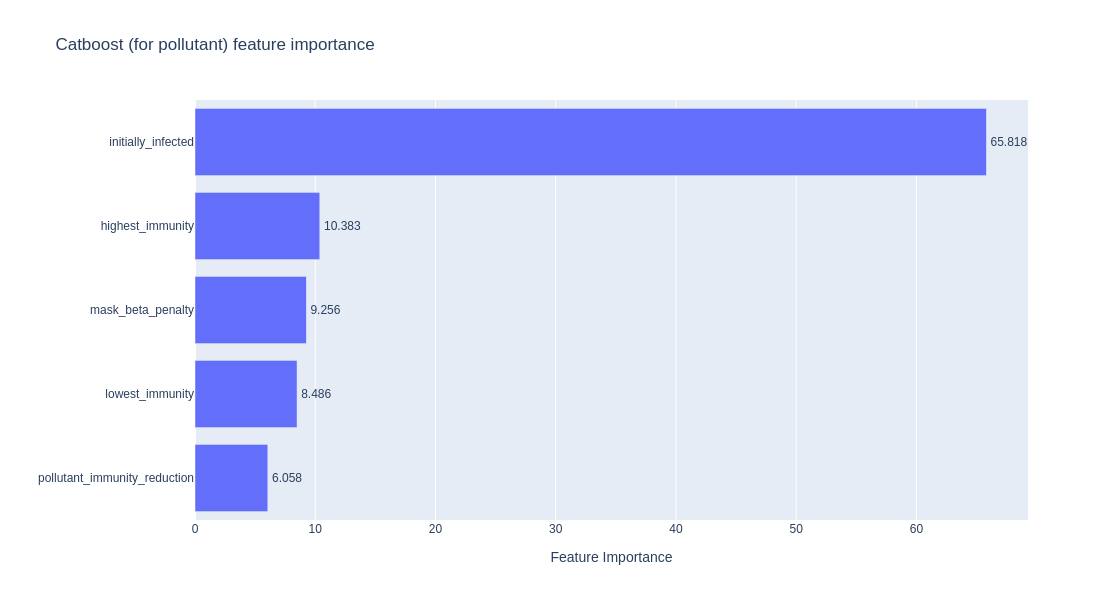

In [10]:
plot_feature_importance(importance=pollutant_model.get_feature_importance(),
                        names=pollutant_cols,
                        model_type="Catboost (for pollutant)")

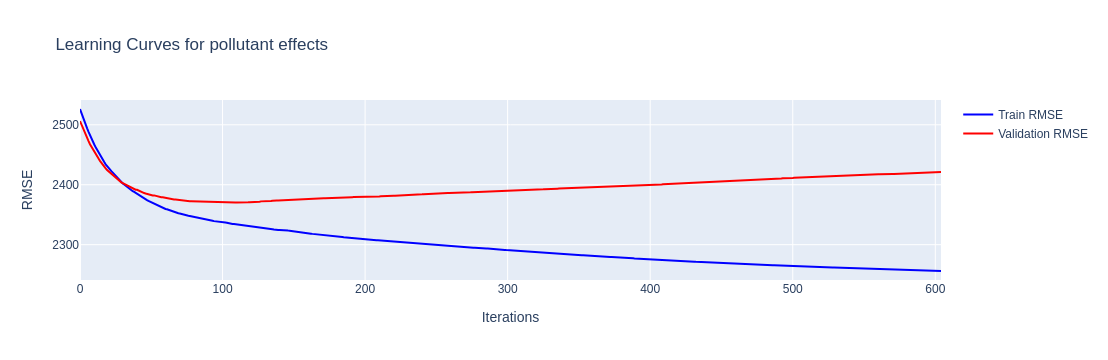

In [11]:
plot_learning_curves(model=pollutant_model, model_description="pollutant effects")

## Модель с фокусом на загрязнитель + $\beta$

In [12]:
cols = [
    'beta',
    'initially_infected',
    'lowest_immunity',
    'highest_immunity',
    'mask_beta_penalty',
    'pollutant_immunity_reduction',
    ]
training_data = df[[*cols, TARGET]]
training_data.head()

,beta,initially_infected,lowest_immunity,highest_immunity,mask_beta_penalty,pollutant_immunity_reduction,infected_90d
0,0.17,4,0.2,0.75,0.50,0.2,2769
1,0.09,4,0.1,0.75,0.50,0.1,3258
2,0.01,6,0.3,0.60,0.50,0.3,166
3,0.01,6,0.3,0.60,0.50,0.1,144
4,0.01,10,0.2,0.75,0.25,0.3,351


In [13]:
X = training_data[cols]
y = training_data[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

In [14]:
model = CatBoostRegressor(
    iterations=10000,
    learning_rate=0.025,
    depth=5,
    loss_function='RMSE',
    random_seed=RANDOM_STATE,
    verbose=False,
    early_stopping_rounds=500)

model.fit(X_train,
          y_train,
          eval_set=(X_test, y_test),
          plot=False)
model.best_score_

{'learn': {'RMSE': 476.4099269881833},
 'validation': {'RMSE': 535.5501316646842}}

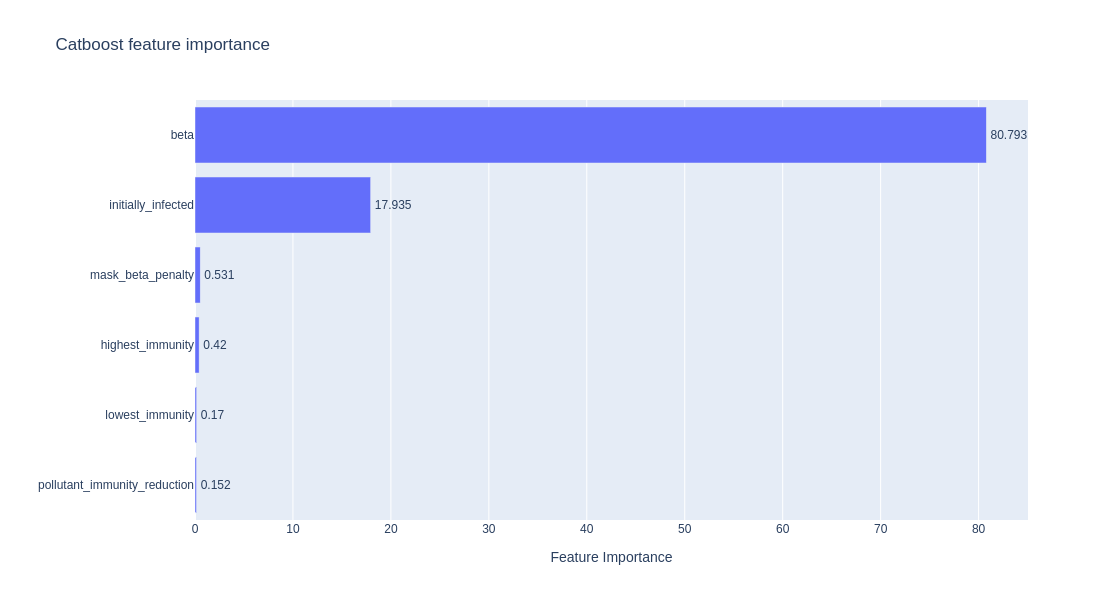

In [15]:
plot_feature_importance(importance=model.get_feature_importance(),
                        names=cols,
                        model_type="Catboost")

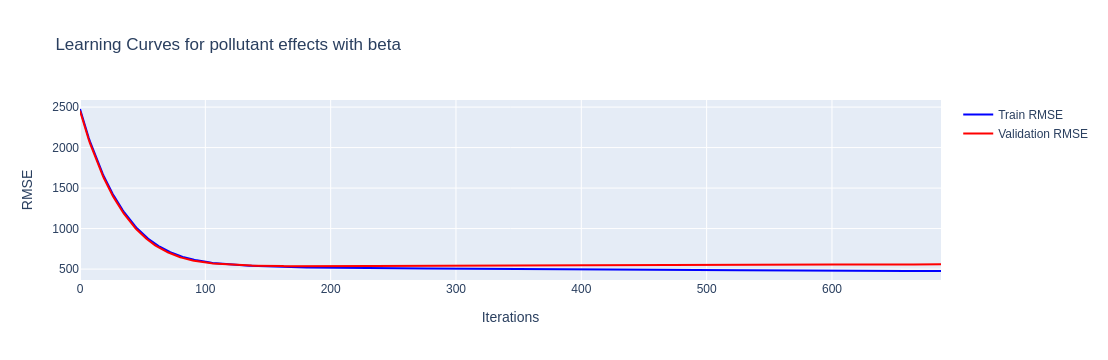

In [16]:
plot_learning_curves(model=model, model_description="pollutant effects with beta")

## Загрузка моделей

In [ ]:
notebook_login()

### Модель с фокусом на загрязнитель

#### Документация модели

In [ ]:

pollutant_model_name = "agentic_disease_spread_catboost_pollutant"
pollutant_model_filename = f"{pollutant_model_name}.joblib"

joblib.dump(pollutant_model, pollutant_model_filename)

# Create model card
pollutant_model_card = """
---
language: en
tags:
- catboost
- regression
- machine-learning
- tabular-data
- gradient-boosting
library_name: catboost
widget:
- tabular:
    example_title: "Sample Prediction"
    data:
      initially_infected: [4, 6]
      lowest_immunity: [0.2, 0.1]
      highest_immunity: [0.75, 0.75]
      mask_beta_penalty: [0.5, 0.5]
      pollutant_immunity_reduction: [0.2, 0.1]
---

# Agentic Disease Spread CatBoost Regressor Model for Pollutant effects

## Model Description

This is a CatBoost Regressor model trained for regression tasks on tabular data
created by simulations from [Agent-based Implementations for Infectious Disease Transmission Models](https://github.com/AlekseiAgarkov/AgenticInfectiousDiseaseTransmissionModels)
simulator.
CatBoost (Categorical Boosting) is a gradient boosting library developed
by Yandex that excels at handling categorical features natively without extensive preprocessing.

- **Model type:** Gradient Boosting Decision Trees
- **Task:** Regression
- **License:** MIT
- **Repository:** https://github.com/AlekseiAgarkov/AgenticInfectiousDiseaseTransmissionModels

## Intended Uses & Limitations

### Intended Use
- Regression analysis on structured/tabular disease spread agentic simulations data
- Scenarios with pollutant effects

### Limitations
- Primarily designed for pollutant effects checking
- Not suitable for unstructured data (images, text, audio)

## How to Use

### Installation
```bash
pip install catboost
```

### Basic Usage
```python
import pickle
import pandas as pd
from catboost import CatBoostRegressor

# Load the model
with open('catboost_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Prepare your data (as pandas DataFrame)
# Ensure features match training data format
data = pd.DataFrame({
    'initially_infected': [value1]
    'lowest_immunity': [value2]
    'highest_immunity': [value3]
    'mask_beta_penalty': [value4]
    'pollutant_immunity_reduction': [value5]
})

# Make prediction
prediction = model.predict(data)
```

### Using with CatBoost directly
```python
from catboost import CatBoostRegressor

# Load saved model
model = CatBoostRegressor()
model.load_model('catboost_model.cbm')

# Make predictions
predictions = model.predict(data)
```

## Training Procedure

### Training Data
Data details:
- Source: https://raw.githubusercontent.com/AlekseiAgarkov/MIFIML-2-Sem1-M25-525-Project-Practice/refs/heads/main/data/sim_data_metrics_20251214.csv
- Features:
  - initially_infected: int - number of initially infected agents
  - lowest_immunity: float - lowest possible immunity in simulation
  - highest_immunity: float - highest possible immunity in simulation
  - mask_beta_penalty: float - beta reduction coefficient for a mask weared at contact
  - pollutant_immunity_reduction: float - immunity reduction coefficient for pollutant
- Target variable: 'infected_90d'
- Samples: 2000
- Preprocessing: None

### Training Hyperparameters
```yaml
iterations: 10000
learning_rate: 0.025
depth: 5
loss_function: 'RMSE'
cat_features: None
verbose: False
early_stopping_rounds: 500
random_seed: 42
```

### Evaluation Results

|       Metric      |  Value  |
|-------------------|---------|
| Train RMSE        | 2256.11 |
| Validation RMSE   | 2369.69 |


## Feature Information

|            Feature Name      |   Type  |              Description                                | Importance |
|------------------------------|---------|---------------------------------------------------------|------------|
| initially_infected           | Numeric | number of initially infected agents                     | 65.82      |
| lowest_immunity              | Numeric | lowest possible immunity in simulation                  | 8.49       |
| highest_immunity             | Numeric | highest possible immunity in simulation                 | 10.38      |
| mask_beta_penalty            | Numeric | beta reduction coefficient for a mask weared at contact | 9.26       |
| pollutant_immunity_reduction | Numeric | immunity reduction coefficient for pollutant            | 6.06       |

## Model Architecture

- **Algorithm:** Gradient Boosting on Decision Trees
- **Number of trees:** [value]
- **Tree depth:** 5
- **Learning rate:** 0.025
- **Loss function:** RMSE
- **Feature importance type:** default

## Model Card Authors
Aleksei Agarkov / MEPhI

## Model Card Contact
agarkov.aleksei1@yandex.ru

## Disclaimer

This model is provided "as is" without warranty of any kind. Users should evaluate the model's suitability for their specific use case and perform appropriate testing before deployment in production environments.
"""

In [ ]:
with open("README.md", "w") as f:
  f.write(pollutant_model_card)

#### Загрузка

In [ ]:
repo_name = f"agarkov-aleksei1/20251214-{pollutant_model_name}-infected_90d"
create_repo(repo_name, exist_ok=True)

api = HfApi()
api.upload_file(
    path_or_fileobj=pollutant_model_filename,
    path_in_repo=pollutant_model_filename,
    repo_id=repo_name,
)

api.upload_file(
    path_or_fileobj="README.md",
    path_in_repo="README.md",
    repo_id=repo_name,
)

print(f"Model uploaded to: https://huggingface.co/{repo_name}")

### Модель с фокусом на загрязнитель + $\beta$

#### Документация модели

In [ ]:
model_name = "agentic_disease_spread_catboost_pollutant_with_beta"
model_filename = f"{model_name}.joblib"

joblib.dump(model, model_filename)

# Create model card
model_card = """
---
language: en
tags:
- catboost
- regression
- machine-learning
- tabular-data
- gradient-boosting
library_name: catboost
widget:
- tabular:
    example_title: "Sample Prediction"
    data:
      initially_infected: [4, 6]
      lowest_immunity: [0.2, 0.1]
      highest_immunity: [0.75, 0.75]
      mask_beta_penalty: [0.5, 0.5]
      pollutant_immunity_reduction: [0.2, 0.1]
---

# Agentic Disease Spread CatBoost Regressor Model for Pollutant effects with Beta

## Model Description

This is a CatBoost Regressor model trained for regression tasks on tabular data
created by simulations from [Agent-based Implementations for Infectious Disease Transmission Models](https://github.com/AlekseiAgarkov/AgenticInfectiousDiseaseTransmissionModels)
simulator.
CatBoost (Categorical Boosting) is a gradient boosting library developed
by Yandex that excels at handling categorical features natively without extensive preprocessing.

- **Model type:** Gradient Boosting Decision Trees
- **Task:** Regression
- **License:** MIT
- **Repository:** https://github.com/AlekseiAgarkov/AgenticInfectiousDiseaseTransmissionModels

## Intended Uses & Limitations

### Intended Use
- Regression analysis on structured/tabular disease spread agentic simulations data
- Scenarios with pollutant effects

### Limitations
- Primarily designed for pollutant effects checking
- Not suitable for unstructured data (images, text, audio)

## How to Use

### Installation
```bash
pip install catboost
```

### Basic Usage
```python
import pickle
import pandas as pd
from catboost import CatBoostRegressor

# Load the model
with open('catboost_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Prepare your data (as pandas DataFrame)
# Ensure features match training data format
data = pd.DataFrame({
    'beta': [value0],
    'initially_infected': [value1],
    'lowest_immunity': [value2],
    'highest_immunity': [value3],
    'mask_beta_penalty': [value4],
    'pollutant_immunity_reduction': [value5]
})

# Make prediction
prediction = model.predict(data)
```

### Using with CatBoost directly
```python
from catboost import CatBoostRegressor

# Load saved model
model = CatBoostRegressor()
model.load_model('catboost_model.cbm')

# Make predictions
predictions = model.predict(data)
```

## Training Procedure

### Training Data
Data details:
- Source: https://raw.githubusercontent.com/AlekseiAgarkov/MIFIML-2-Sem1-M25-525-Project-Practice/refs/heads/main/data/sim_data_metrics_20251214.csv
- Features:
  - beta: float - infectivity coefficient (`beta`)
  - initially_infected: int - number of initially infected agents
  - lowest_immunity: float - lowest possible immunity in simulation
  - highest_immunity: float - highest possible immunity in simulation
  - mask_beta_penalty: float - beta reduction coefficient for a mask weared at contact
  - pollutant_immunity_reduction: float - immunity reduction coefficient for pollutant
- Target variable: 'infected_90d'
- Samples: 2000
- Preprocessing: None

### Training Hyperparameters
```yaml
iterations: 10000
learning_rate: 0.025
depth: 5
loss_function: 'RMSE'
cat_features: None
verbose: False
early_stopping_rounds: 500
random_seed: 42
```

### Evaluation Results

|       Metric      |  Value |
|-------------------|--------|
| Train RMSE        | 476.41 |
| Validation RMSE   | 535.55 |

## Feature Information

|            Feature Name      |   Type  |              Description                                | Importance |
|------------------------------|---------|---------------------------------------------------------|------------|
| beta                         | Numeric | infectivity coefficient (`beta`)                        | 80.79      |
| initially_infected           | Numeric | number of initially infected agents                     | 17.94      |
| lowest_immunity              | Numeric | lowest possible immunity in simulation                  | 0.17       |
| highest_immunity             | Numeric | highest possible immunity in simulation                 | 0.42       |
| mask_beta_penalty            | Numeric | beta reduction coefficient for a mask weared at contact | 0.53       |
| pollutant_immunity_reduction | Numeric | immunity reduction coefficient for pollutant            | 0.15       |

## Model Architecture

- **Algorithm:** Gradient Boosting on Decision Trees
- **Number of trees:** 188
- **Tree depth:** 5
- **Learning rate:** 0.025
- **Loss function:** RMSE
- **Feature importance type:** default

## Model Card Authors
Aleksei Agarkov / MEPhI

## Model Card Contact
agarkov.aleksei1@yandex.ru

## Disclaimer

This model is provided "as is" without warranty of any kind. Users should evaluate the model's suitability for their specific use case and perform appropriate testing before deployment in production environments.
"""

In [ ]:
with open("README.md", "w") as f:
  f.write(model_card)

#### Загрузка

In [ ]:
repo_name = f"agarkov-aleksei1/20251214-{model_name}-infected_90d"
create_repo(repo_name, exist_ok=True)

api = HfApi()
api.upload_file(
    path_or_fileobj=model_filename,
    path_in_repo=model_filename,
    repo_id=repo_name,
)

api.upload_file(
    path_or_fileobj="README.md",
    path_in_repo="README.md",
    repo_id=repo_name,
)

print(f"Model uploaded to: https://huggingface.co/{repo_name}")

## Загрузка датасетов

In [ ]:
notebook_login()

In [ ]:
api = HfApi()

### Модель с фокусом на загрязнитель

#### Документация датасета

In [ ]:
pollutant_model_dataset_name = "20251214-agentic_disease_spread_catboost_pollutant-infected_90d-dataset"
pollutant_model_dataset_repo_name = f"agarkov-aleksei1/{pollutant_model_dataset_name}"
pollutant_model_dataset_path = f"/content/{pollutant_model_dataset_name}"
Path(f"{pollutant_model_dataset_path}/data").mkdir(exist_ok=True, parents=True)

In [ ]:
pollutant_model_features = Features({
 "initially_infected": Value("int64"),
 "lowest_immunity": Value("double"),
 "highest_immunity": Value("double"),
 "mask_beta_penalty": Value("double"),
 "pollutant_immunity_reduction": Value("double"),
 "infected_90d": Value("int64"),
 })

pollutant_model_dataset_info = DatasetInfo(
    description="Data from Agent-based Infectious Disease Transmission Model Simulator",
    homepage="https://github.com/AlekseiAgarkov/AgenticInfectiousDiseaseTransmissionModels",
    features=pollutant_model_features
)

pollutant_model_dataset_card_data = DatasetCardData(
    homepage="https://github.com/AlekseiAgarkov/AgenticInfectiousDiseaseTransmissionModels",
    language="en",
    license="mit",
    annotations_creators=["Aleksei Agarkov / MEPhI"],
    task_categories=["tabular-regression"],
    task_ids=["tabular-single-column-regression"],
    pretty_name="Data from Agent-based Infectious Disease Transmission Model Simulator",
    size_categories=["1K<n<10K"],
    tags=["regression", "simulated", "english", "epidemic"],
)

pollutant_model_dataset_card = f"""---
{pollutant_model_dataset_card_data.to_yaml()}
---

# Dataset Card for "Data from Agent-based Infectious Disease Transmission Model Simulator"
Data from Agent-based Infectious Disease Transmission Model Simulator

## Dataset Details

### Dataset Description

Dataset should be used to perform 'What if?' analysis on the data generated from
the simulator.

- **Curated by:** Aleksei Agarkov
- **License:** MIT

### Dataset Sources
- **Repository:** https://github.com/AlekseiAgarkov/AgenticInfectiousDiseaseTransmissionModels

## Uses

Dataset should be used to perform 'What if?' analysis on the data generated from
the simulator.

## Dataset Structure

### Features
- initially_infected - Number of initially infected agents
- lowest_immunity - Lowest possible immunity in simulation
- highest_immunity - Highest possible immunity in simulation
- mask_beta_penalty - Beta reduction coefficient for a mask weared at contact
- pollutant_immunity_reduction - Immunity reduction coefficient for pollutant
- infected_90d - Regression Target. Number of infected agents by day 90.


## Dataset Card Authors [optional]
Aleksei Agarkov / MEPhI

## Dataset Card Contact
agarkov.aleksei1@yandex.ru
"""

In [ ]:
pollutant_train = Dataset.from_pandas(pd.concat([pollutant_X_train, pollutant_y_train], axis=1).reset_index(drop=True), features=pollutant_model_features)
pollutant_test = Dataset.from_pandas(pd.concat([pollutant_X_test, pollutant_y_test], axis=1).reset_index(drop=True), features=pollutant_model_features)
pollutant_dataset_dict = DatasetDict({"train": pollutant_train,
                                      "test": pollutant_test})

In [ ]:
with open(f"{pollutant_model_dataset_path}/README.md", "w") as f:
  f.write(pollutant_model_dataset_card)

#### Загрузка

In [ ]:
create_repo(pollutant_model_dataset_repo_name,
            repo_type="dataset",
            exist_ok=True)

pollutant_dataset_dict.push_to_hub(
    pollutant_model_dataset_repo_name,
    private=False,
    commit_message="Initial commit"
)

api.upload_file(
    path_or_fileobj=f"{pollutant_model_dataset_path}/README.md",
    path_in_repo="README.md",
    repo_type="dataset",
    repo_id=pollutant_model_dataset_repo_name,
)

print(f"Dataset uploaded to: https://huggingface.co/{pollutant_model_dataset_repo_name}")

### Модель с фокусом на загрязнитель + $\beta$

#### Документация датасета

In [ ]:
model_dataset_name = "20251214-agentic_disease_spread_catboost_pollutant_with_beta-infected_90d-dataset"
model_dataset_repo_name = f"agarkov-aleksei1/{model_dataset_name}"
model_dataset_path = f"/content/{model_dataset_name}"
Path(f"{model_dataset_path}/data").mkdir(exist_ok=True, parents=True)

In [ ]:
model_features = Features({
 "initially_infected": Value("int64"),
 "lowest_immunity": Value("double"),
 "highest_immunity": Value("double"),
 "mask_beta_penalty": Value("double"),
 "pollutant_immunity_reduction": Value("double"),
 "beta": Value("double"),
 "infected_90d": Value("int64"),
 })

model_dataset_info = DatasetInfo(
    description="Data from Agent-based Infectious Disease Transmission Model Simulator",
    homepage="https://github.com/AlekseiAgarkov/AgenticInfectiousDiseaseTransmissionModels",
    features=model_features
)

model_dataset_card_data = DatasetCardData(
    homepage="https://github.com/AlekseiAgarkov/AgenticInfectiousDiseaseTransmissionModels",
    language="en",
    license="mit",
    annotations_creators=["Aleksei Agarkov / MEPhI"],
    task_categories=["tabular-regression"],
    task_ids=["tabular-single-column-regression"],
    pretty_name="Data from Agent-based Infectious Disease Transmission Model Simulator",
    size_categories=["1K<n<10K"],
    tags=["regression", "simulated", "english", "epidemic"],
)

model_dataset_card = f"""---
{model_dataset_card_data.to_yaml()}
---

# Dataset Card for "Data from Agent-based Infectious Disease Transmission Model Simulator"
Data from Agent-based Infectious Disease Transmission Model Simulator

## Dataset Details

### Dataset Description

Dataset should be used to perform 'What if?' analysis on the data generated from
the simulator.

- **Curated by:** Aleksei Agarkov
- **License:** MIT

### Dataset Sources
- **Repository:** https://github.com/AlekseiAgarkov/AgenticInfectiousDiseaseTransmissionModels

## Uses

Dataset should be used to perform 'What if?' analysis on the data generated from
the simulator.

## Dataset Structure

### Features
- initially_infected - Number of initially infected agents
- lowest_immunity - Lowest possible immunity in simulation
- highest_immunity - Highest possible immunity in simulation
- mask_beta_penalty - Beta reduction coefficient for a mask weared at contact
- pollutant_immunity_reduction - Immunity reduction coefficient for pollutant
- beta - Infectivity coefficient
- infected_90d - Regression Target. Number of infected agents by day 90.


## Dataset Card Authors [optional]
Aleksei Agarkov / MEPhI

## Dataset Card Contact
agarkov.aleksei1@yandex.ru
"""

In [ ]:
model_train = Dataset.from_pandas(pd.concat([X_train, y_train], axis=1).reset_index(drop=True), features=model_features)
model_test = Dataset.from_pandas(pd.concat([X_test, y_test], axis=1).reset_index(drop=True), features=model_features)
model_dataset_dict = DatasetDict({"train": model_train,
                                  "test": model_test})

In [ ]:
with open(f"{model_dataset_path}/README.md", "w") as f:
  f.write(model_dataset_card)

#### Загрузка

In [ ]:
create_repo(model_dataset_repo_name,
            repo_type="dataset",
            exist_ok=True)

model_dataset_dict.push_to_hub(
    model_dataset_repo_name,
    private=False,
    commit_message="Initial commit"
)

api.upload_file(
    path_or_fileobj=f"{model_dataset_path}/README.md",
    path_in_repo="README.md",
    repo_type="dataset",
    repo_id=model_dataset_repo_name,
)

print(f"Dataset uploaded to: https://huggingface.co/{model_dataset_repo_name}")